In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2

In [73]:
def get_cond_prob(bit_string_counts, n_data):
    # convert count dict to pd frame
    df = pd.DataFrame.from_dict(
        bit_string_counts, orient='index').reset_index()
    df.columns = ['bits', 'counts']

    # split data and ancilla
    df['data_bits'] = df['bits'].str[-n_data:]
    df['bath_bits'] = df['bits'].str[:-n_data]
    df = df.drop('bits', axis=1)

    # find result with 00 data bit
    A0_bits = df[df['data_bits'] == '0'*n_data]
    A0_bits = A0_bits.rename(
        columns={'counts': 'cond_counts'}).drop('data_bits', axis=1)

    # compute cond prob using left merge
    ZB_df = df.groupby('bath_bits').sum(numeric_only=True).reset_index()
    ZB_df = ZB_df.merge(A0_bits, on='bath_bits', how='left').fillna(0)
    ZB_df['cond_prob'] = ZB_df['cond_counts'] / ZB_df['counts']
    ZB_df = ZB_df.drop(['cond_counts', 'bath_bits'], axis=1)

    # expand into long format
    # ZB_df = ZB_df.reindex(ZB_df.index.repeat(ZB_df['counts']))

    return ZB_df['cond_prob'].to_numpy()


def pt_density(x, d):
    return (2 ** d - 1) * (1 - x) ** (2 ** d - 2)

In [13]:
def create_circuit(n_step, n_depth, n_data, n_bath):
    n_wires = n_data + n_bath
    n_param = 2 * n_depth * n_step
    n_register = n_data + n_bath * n_step

    # circuit parameter storages
    param_data = [ParameterVector(
        'data_' + str(d), length=n_param) for d in range(n_data)]
    param_bath = [ParameterVector(
        'bath_' + str(b), length=n_param) for b in range(n_bath)]

    q = QuantumRegister(n_wires, 'q')
    c = ClassicalRegister(n_register, 'c')
    circuit = QuantumCircuit(q, c)

    for t in range(n_step):
        for d in range(n_depth):
            param_id = 2 * d + 2 * n_depth * t
            for i in range(n_data):
                circuit.ry(param_data[i][param_id], i)
                circuit.rz(param_data[i][param_id + 1], i)

            for i in range(n_bath):
                circuit.ry(param_bath[i][param_id], n_data + i)
                circuit.rz(param_bath[i][param_id + 1], n_data + i)

            for i in range(n_wires//2):
                circuit.cx(2*i, 2*i+1)

            for i in range((n_wires - 1)//2):
                circuit.cx(2*i+1, 2*i+2)

        register_id = n_data + t * n_bath
        circuit.measure(range(n_data, n_wires), range(
            register_id, register_id + n_bath))

        if t < n_step - 1:
            for b in range(n_bath):
                circuit.reset(n_data + b)

    circuit.measure(range(n_data), range(n_data))

    return circuit

In [ ]:
_, token = open('./api_token.txt','r').read().split()
service = QiskitRuntimeService(
    channel='ibm_quantum',
    token=token
)

## $N_a=2$

In [138]:
# backend = service.least_busy(operational=True, simulator=False, min_num_qubits=10)
backend = service.backend("ibm_sherbrooke")
session = Session(backend=backend)
sampler = SamplerV2(mode=session)

In [139]:
sampler.options.execution.rep_delay = 0.0005

In [140]:
# parameters
n_shot = int(1e5)
n_depth = 4
n_data = 2
n_bath = 2

steps = [1, 3, 5, 6]

In [141]:
np.random.seed(12345)
for n_step in steps:
    circuit = create_circuit(n_step, n_depth, n_data, n_bath)
    transpiled_circuit = transpile(circuit, backend)
    
    n_total_param = (n_data + n_bath) * (2 * n_depth * n_step)
    param_random = np.random.uniform(0, 4. * np.pi, n_total_param)
    bound_circuit = transpiled_circuit.assign_parameters(param_random)

    job = sampler.run([bound_circuit], shots=n_shot)

session.close()

Text(0.5, 0.95, 'IBM, Na=2, Nb=2, L=4, shots=100000')

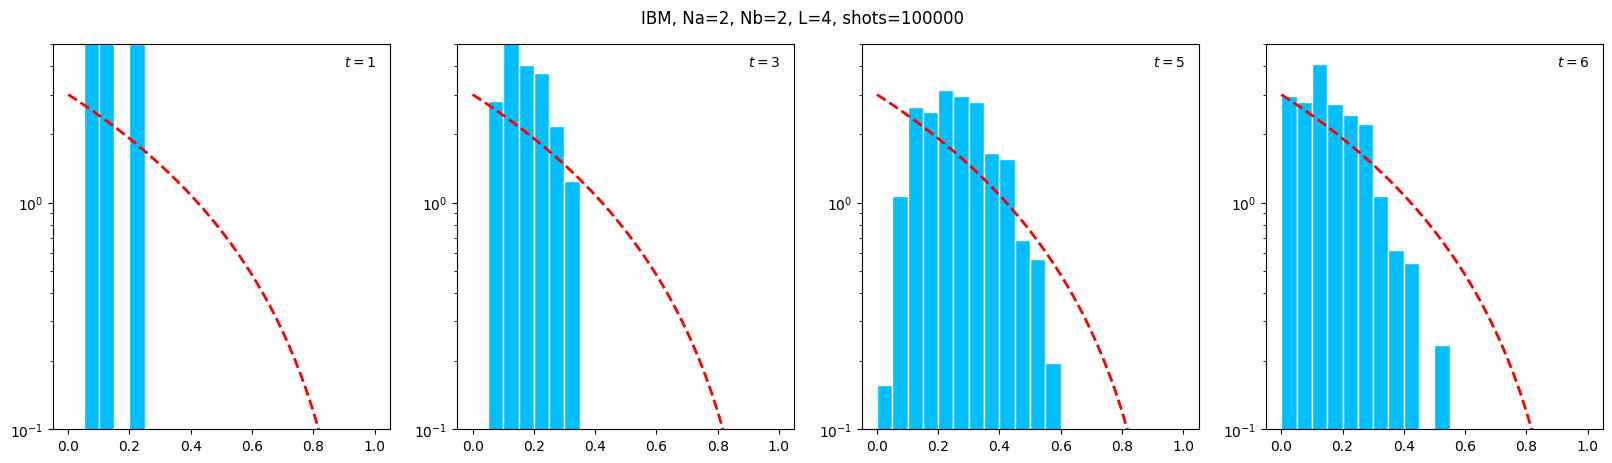

In [142]:
jobs = service.jobs(session_id='')

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
qs = np.linspace(0, 100, 51)/100
for i, job in enumerate(reversed(jobs)):
    res = job.result()[0].data.c.get_counts()
    cond_p = get_cond_prob(res, n_data)

    axs[i].hist(cond_p, bins=np.linspace(0, 1, 21), density=True, color='deepskyblue', edgecolor='white',
                label='$t={}$'.format(steps[i]))
    axs[i].plot(qs, pt_density(qs, n_data), '--', lw=2, color='r')
    axs[i].set_yscale('log')
    axs[i].set_ylim(0.1, 5)
    axs[i].text(0.9, 4, '$t={}$'.format(steps[i]))
fig.suptitle('IBM, Na={}, Nb={}, L={}, shots={}'.format(n_data, n_bath, n_depth, n_shot), y=0.95)

## $N_a=3$

In [147]:
backend = service.backend("ibm_sherbrooke")
session = Session(backend=backend)
sampler = SamplerV2(mode=session)

In [148]:
n_shot = int(1e5)
n_depth = 6
n_data = 3
n_bath = 3

steps = [1, 2, 3, 4]

In [149]:
np.random.seed(12345)
for n_step in steps:
    circuit = create_circuit(n_step, n_depth, n_data, n_bath)
    transpiled_circuit = transpile(circuit, backend)
    
    n_total_param = (n_data + n_bath) * (2 * n_depth * n_step)
    param_random = np.random.uniform(0, 4. * np.pi, n_total_param)
    bound_circuit = transpiled_circuit.assign_parameters(param_random)

    job = sampler.run([bound_circuit], shots=n_shot)

session.close()

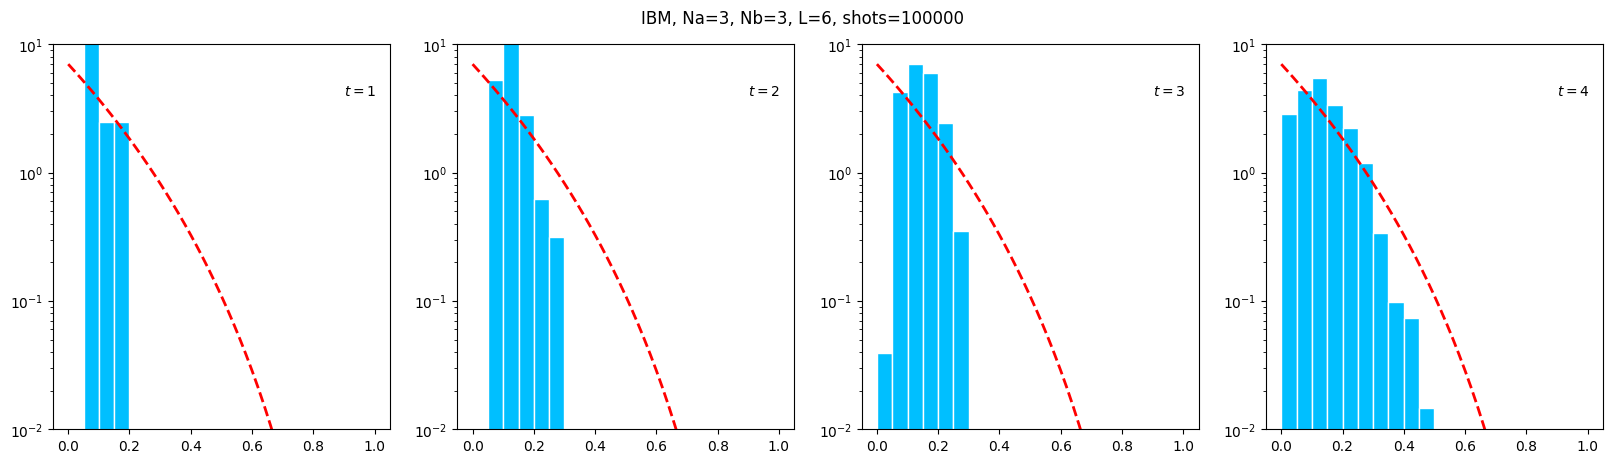

In [144]:
jobs = service.jobs(session_id='')

n_data = 3
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
qs = np.linspace(0, 100, 51)/100
for i, job in enumerate(reversed(jobs)):
    res = job.result()[0].data.c.get_counts()
    cond_p = get_cond_prob(res, n_data)
    axs[i].hist(cond_p, bins=np.linspace(0, 1, 21), density=True, color='deepskyblue', edgecolor='white',
                label='$t={}$'.format(steps[i]))
    axs[i].plot(qs, pt_density(qs, n_data), '--', lw=2, color='r')
    axs[i].set_yscale('log')
    axs[i].set_ylim(1e-2, 1e1)
    axs[i].text(0.9, 4, '$t={}$'.format(steps[i]))
fig.suptitle('IBM, Na={}, Nb={}, L={}, shots={}'.format(n_data, n_bath, n_depth, n_shot), y=0.95);

## $N_a = 4$

In [150]:
backend = service.backend("ibm_sherbrooke")
session = Session(backend=backend)
sampler = SamplerV2(mode=session)

In [151]:
n_shot = int(1e5)
n_depth = 8
n_data = 4
n_bath = 4

steps = [1, 2, 3]

In [152]:
np.random.seed(12345)
for n_step in steps:
    circuit = create_circuit(n_step, n_depth, n_data, n_bath)
    transpiled_circuit = transpile(circuit, backend)
    
    np.random.seed(1)
    n_total_param = (n_data + n_bath) * (2 * n_depth * n_step)
    param_random = np.random.uniform(0, 4. * np.pi, n_total_param)
    bound_circuit = transpiled_circuit.assign_parameters(param_random)

    job = sampler.run([bound_circuit], shots=n_shot)

session.close()

Text(0.5, 0.95, 'IBM, Na=4, Nb=4, L=8, shots=100000')

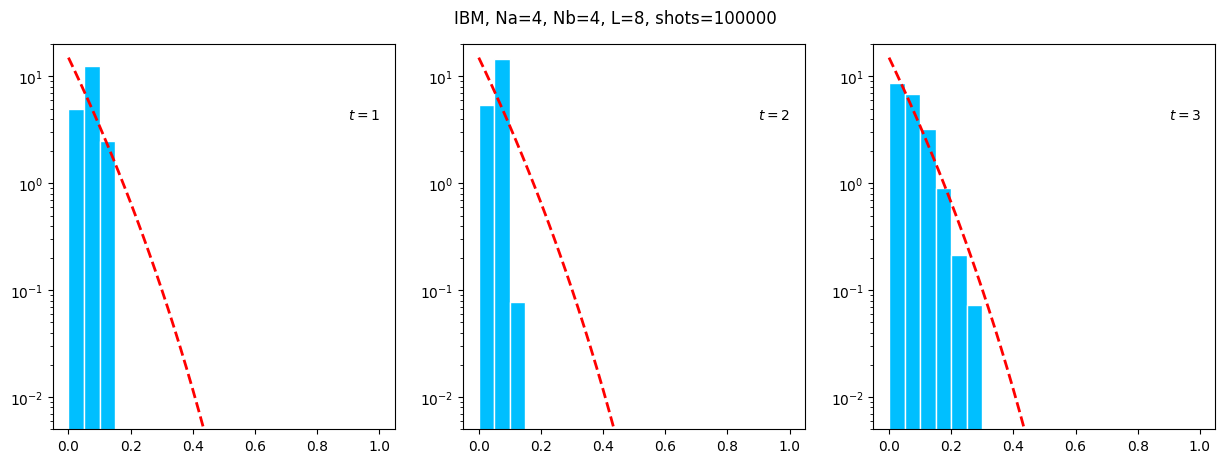

In [146]:
jobs = service.jobs(session_id='')

n_data = 4
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
qs = np.linspace(0, 100, 51)/100
for i, job in enumerate(reversed(jobs)):
    res = job.result()[0].data.c.get_counts()
    cond_p = get_cond_prob(res, n_data)
    axs[i].hist(cond_p, bins=np.linspace(0, 1, 21), density=True, color='deepskyblue', edgecolor='white',
                label='$t={}$'.format(steps[i]))
    axs[i].plot(qs, pt_density(qs, n_data), '--', lw=2, color='r')
    axs[i].set_yscale('log')
    axs[i].set_ylim(5e-3, 20)
    axs[i].text(0.9, 4, '$t={}$'.format(steps[i]))
fig.suptitle('IBM, Na={}, Nb={}, L={}, shots={}'.format(n_data, n_bath, n_depth, n_shot), y=0.95)